In [1]:
import geopandas as gpd
import pandas as pd, numpy as np

import rasterio as rio
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm
from rasterio.mask import mask

In [2]:
dist = "../Data/gjson/adm_3.geojson"
tiff = "../Data/Raster/Population/eth_ppp_2020_constrained.tif"

In [3]:
dist_gdf = gpd.read_file(dist)
sample = dist_gdf.sample(1)
sample

,id,fnid,name,unit_type_code,parent_id,start_date,end_date,country_code,fewsnet_region,geographic_group,...,layer_id,layer_name,geographicunitsetversion_name,zone_type,urban_rural,start_month,area,attributes,fid,geometry
667,223463,ET2023A3041805,Sayo,admin3,222739,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,1123.0,"{'FNID': 'ET2023A3041805', 'ADMIN0': 'Ethiopia...",667,"MULTIPOLYGON (((34.80300 8.70800, 34.80256 8.7..."


In [4]:
dist_gdf.columns

Index(['id', 'fnid', 'name', 'unit_type_code', 'parent_id', 'start_date',
       'end_date', 'country_code', 'fewsnet_region', 'geographic_group',
       'full_name', 'es_name', 'fr_name', 'pt_name', 'ar_name', 'unit_type',
       'country', 'admin_0', 'admin_1', 'admin_2', 'admin_3', 'admin_4',
       'layer_id', 'layer_name', 'geographicunitsetversion_name', 'zone_type',
       'urban_rural', 'start_month', 'area', 'attributes', 'fid', 'geometry'],
      dtype='object')

In [5]:
cols_dataref = ["admin_0", "admin_1", "admin_2", "admin_3"]
metrics = [np.mean, np.std, np.sum]
metric_value = "population"
with rio.open(tiff) as src:
    out_image, out_transform = mask(src, sample.geometry, crop=True)

ref_df = sample[cols_dataref]
values = out_image.flatten()
rows, cols = np.indices(out_image.shape[-2:])
x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())
data = {"x": x, "y": y, "z": values}
data = pd.DataFrame(data).query("z>0").dropna()

In [6]:
stats = data["z"].agg(metrics).values.flatten()
(
    ref_df[f"{metric_value}_mean"],
    ref_df[f"{metric_value}_sd"],
    ref_df[f"{metric_value}_sum"],
) = stats
ref_df

,admin_0,admin_1,admin_2,admin_3,population_mean,population_sd,population_sum
667,Ethiopia,Oromia,Kelem,Sayo,16.976933,8.395747,187017.890625


<Axes: >

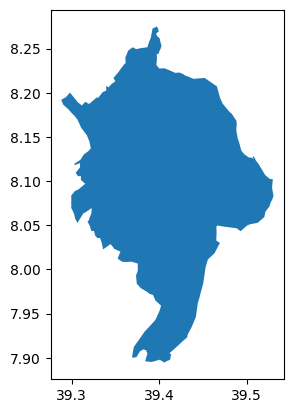

In [7]:
def get_data_raster_shapefile(
    path_tiff: str = tiff,
    shp_gdf: gpd.GeoDataFrame = sample,
    cols_dataref=["admin_0", "admin_1", "admin_2", "admin_3"],
    metrics=[np.mean, np.std, np.sum],
    metric_value="population",
):

    with rio.open(path_tiff) as src:
        out_image, out_transform = mask(src, shp_gdf.geometry, crop=True)
    temp_gdf = shp_gdf.copy()
    shp_gdf = shp_gdf[cols_dataref]
    values = out_image.flatten()
    rows, cols = np.indices(out_image.shape[-2:])
    x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())
    data = {"x": x, "y": y, "z": values}
    data = pd.DataFrame(data).query("z>0").dropna()
    stats = data["z"].agg(metrics).values.flatten()
    (
        shp_gdf[f"{metric_value}_mean"],
        shp_gdf[f"{metric_value}_sd"],
        shp_gdf[f"{metric_value}_sum"],
    ) = stats
    return shp_gdf, (temp_gdf, out_image, out_transform)

result, metadata = get_data_raster_shapefile(shp_gdf=dist_gdf.sample(1))
# result
metadata[0].plot()

In [3]:
import numpy as np

# Definir el array de números
array_numeros = np.array([1, 2, 3, None, 5, 6, np.nan, 8, 9, 10])

# Filtrar los valores mayores que 0 y no sean None o NaN
array_filtrado = array_numeros[~np.isnan(array_numeros)]

# Calcular las métricas para el array filtrado
metrics = [np.mean, np.std, np.sum]
resultados = [metric(array_filtrado) for metric in metrics]

# Imprimir los resultados
for metric, resultado in zip(metrics, resultados):
    print(f"{metric.__name__}: {resultado}")


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [6]:
import numpy as np

# Definir el array de números
array_numeros = np.array([1, 2, 3, None, 5, 6, np.nan, 8, 9, 10]).astype(float)

# Filtrar los valores None y NaN
array_filtrado = array_numeros[~np.isnan(array_numeros)]  # Convertir a float antes de verificar NaN

# Filtrar los valores mayores que 0
array_filtrado = array_filtrado[array_filtrado > 0]

# Calcular las métricas para el array filtrado
metrics = [np.mean, np.std, np.sum]
resultados = [metric(array_filtrado) for metric in metrics]

# Imprimir los resultados
# for metric, resultado in zip(metrics, resultados):
#     print(f"{metric.__name__}: {resultado}")

resultados

[5.5, 3.122498999199199, 44.0]

In [8]:
# total_rows = len(dist_gdf.sample(10))
total_rows = len(dist_gdf)
result_df = pd.DataFrame()
for row in tqdm(range(total_rows)):
    # print(row)
    row_gdf = dist_gdf.iloc[row:row+1]
    result, metadata = get_data_raster_shapefile(shp_gdf=row_gdf)
    result_df = pd.concat((result_df, result))
result_df


  0%|          | 0/1141 [00:00<?, ?it/s]

100%|██████████| 1141/1141 [28:54<00:00,  1.52s/it] 


,admin_0,admin_1,admin_2,admin_3,population_mean,population_sd,population_sum
0,Ethiopia,Tigray,Northwest Tigray,Tahtay Adiyabo,4.212515,1.767040,87607.679688
1,Ethiopia,Tigray,Northwest Tigray,Zana,7.356061,2.275458,62916.386719
2,Ethiopia,Tigray,Northwest Tigray,Tahtay Koraro,6.054163,2.649188,96479.140625
3,Ethiopia,Tigray,Northwest Tigray,Asgede,5.635667,3.141389,120563.828125
4,Ethiopia,Tigray,Northwest Tigray,Tselemti,6.280854,3.255395,94124.882812
...,...,...,...,...,...,...,...
1136,Ethiopia,Central Ethiopia,Kembata,Adilo,5.317826,5.109311,16070.469727
1137,Ethiopia,Central Ethiopia,Kembata,Shinshincho town,31.200237,17.871035,19094.544922
1138,Ethiopia,Central Ethiopia,Kembata,Hadero town,34.539196,22.393435,33295.785156
1139,Ethiopia,Central Ethiopia,Mareko,Mareko,9.086466,4.936671,81460.164062


In [9]:
result_df.to_csv('../output/population/pop.csv')